In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from graphviz import Digraph
import random
from numpy.random import RandomState
%matplotlib inline
random.seed(42)
custom_np = RandomState(1234567890)

In [2]:
def draw_nn(root):

  def trace(root):
    edges = set()
    nodes  =set ()

    def build(root):
      nodes.add(root)
      for child in root._prev:
        edges.add((child,root))
        build(child)

    build(root)

    return nodes,edges


  nodes, edges = trace(root)

  dot = Digraph(format = "svg",graph_attr={"rankdir":"LR"} )


  for n in nodes:

    uid = str(id(n))

    dot.node(name = uid,label = "{%s | data %.4f |grad %.4f}"%(n.label,n.data,n.grad),shape = "record")


    if(n._op!=''):

      dot.node(name = uid + str(id(n._op)),label = n._op)
      dot.edge(uid+str(id(n._op)),uid)


  for n1,n2 in edges:
      uid1 = str(id(n1))
      uid2 = str(id(n2))
      dot.edge(uid1,uid2+str(id(n2._op)))

  return dot


In [187]:
class Value():

  def __init__(self,data,_prev=(),_op='',label=''):

    self.data = data
    self._prev = _prev
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):

    return(f'Value(data={self.data,self.label})')

  def __add__(self,other):

    other =  other if isinstance(other,Value) else (Value(other))
    out = Value(self.data + other.data,(self,other),"+")

    def _backward():

      self.grad += out.grad
      other.grad += out.grad

    out._backward = _backward

    return out

  def __radd__(self,other):

    return self + other


  def __sub__(self,other):

    other = other if isinstance(other,Value) else (Value(other))

    out = Value(self.data - other.data,(self,other),"-")
    def _backward():

      self.grad += out.grad
      other.grad += out.grad

    out._backward = _backward

    return out

  def __rsub__(self,other):

    return self - other



  def __mul__(self,other):

    other =  other if isinstance(other,Value) else (Value(other))
    out = Value(self.data * other.data,(self,other),"*")

    def _backward():
    
      self.grad +=other.data*out.grad
      other.grad +=self.data*out.grad

    out._backward = _backward

    return out

  def __rmul__(self,other):

    return self*other


  def exp(self):

    out = Value((math.exp(self.data)),(self,),"exp")

    def _backward():
      self.grad += out.data*out.grad

    out._backward = _backward

    return out

  def __neg__(self):

    out = Value(-self.data)
    out.label = "-"+self.label

    def _backward():

      self.grad += self.grad

    out._backward = _backward
    return out


  def __pow__(self,other):

    out = Value((self.data**other),(self,), f"**{other}")

    def _backward():
      self.grad += other * (self.data**(other-1))*out.grad

    out._backward = _backward

    return out

  def __truediv__(self,other):

    out = self * other**-1
    out.label = "/"

    return out


  def tanh(self):

    x = self.data

    t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
    out = Value(t,(self,),"tanh")

    def _backward():

      self.grad += (1-t**2)*out.grad

    out._backward = _backward
    return out

  def relu(self):

    out = Value(max(0,self.data),(self,),"relu")

    def _backward():

        if(self.data<0):
          current_grad = 0
        else:
          current_grad = 1


        self.grad +=current_grad*out.grad

    out._backward = _backward
    return out

  def backward(self):

    self.grad = 1.0
    visited = set()
    # visited.add(self)

    def topological_sort(root):
      if root not in visited:
        root._backward()
        visited.add(root)
        for child in root._prev:
          topological_sort(child)
    topological_sort(self)



    



In [188]:
a = Value(-2,label ="a")
b = Value(7,label = "b")
c = Value(0.2,label = "c")

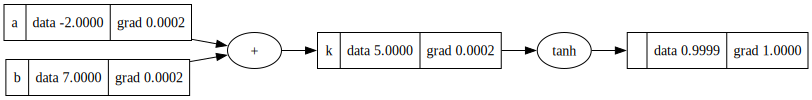

In [189]:
k = a+b;k.label = "k"
final = k.tanh()
# final = k
final.backward()
draw_nn(final)

In [190]:
d = a + b
d.label = "d"
h = d*c
h.label = "h"
output = h.tanh()
# output = h
output.label = "output"

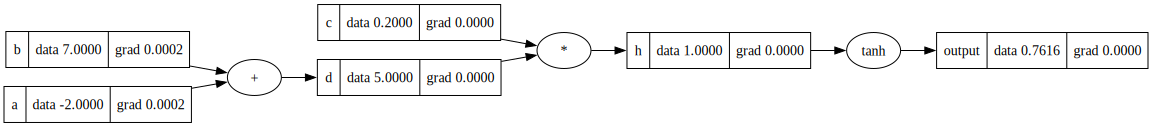

In [191]:
draw_nn(output)

In [192]:
output.backward()

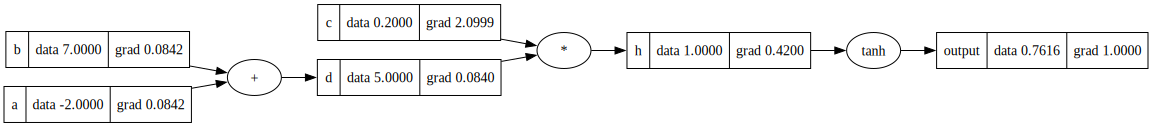

In [193]:
draw_nn(output)

In [200]:
class Neuron():

    def __init__(self,nin,non_linear = True):
        self.w = [Value(random.uniform(-1,1),) for _ in range(nin)]
        
        self.b = Value(0)
        self.non_linear = non_linear
        self.nin = nin

    def __call__(self,x):

        # output = self.b

        output = sum([i*j for i,j in zip(self.w,x)],self.b)
        # for i,j in zip(self.w,x):
        #     output +=i*j

        if(self.non_linear):
            output = output.tanh()

        return output

    def __rep__(self):

        return (f"Neuron with{self.nin} weights")

    
    def paramters(self):

        return self.w +[self.b]
        pass


In [201]:
class Layer():

    def __init__(self,input_neuron,output_neurons):
        self.input_neuron = input_neuron
        self.output_neurons = output_neurons

        self.layer = [Neuron(input_neuron) for i in range(output_neurons)]

    def __call__(self,x):
        output = [neuron(x) for neuron in self.layer]
        return output[0] if len(output) == 1 else output

    def __repr__(self):

        return f" Layer with input of {self.input_neuron} and output of {self.output_neurons}"

    def parameters(self):

        parameters = [p for current_neuron in self.layer for p in current_neuron.paramters()]
        return parameters


In [202]:
class MLP():

    def __init__(self,size_of_layers):

        self.layers = [Layer(size_of_layers[i],size_of_layers[i+1]) for i in range(len(size_of_layers)-1)]


    def __call__(self,x):

        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):

        parameters = [p for p_layer in self.layers for p in p_layer.parameters()]
        return parameters

    def zero_grad(self):

        for current_param in self.parameters():
            current_param.grad = 0.0




In [207]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, 0.0, 0.0, 1.0] # desired targets
learning_rate = 0.01

In [208]:
mlp = MLP([3,4,4,1])

In [209]:
for k in range(20):

    print("*"*40)
    y_pred = []
    for current_x in xs:
        current_pred = mlp(current_x)
        y_pred.append(current_pred)
        # print(current_pred.data)

    mlp.zero_grad()
    loss = sum((i - j)**2 for i,j in zip(y_pred,ys))
    loss.backward()

    for current_param in mlp.parameters():
        current_param.data += -0.1 * current_param.grad

    print(k,loss.data)
    
    
    # break

****************************************
0 4.595576600663817
****************************************
1 0.2464708250882017
****************************************
2 0.10503488553725113
****************************************
3 0.07298782688578831
****************************************
4 0.05466128886668013
****************************************
5 0.043033570009815586
****************************************
6 0.035228540239504544
****************************************
7 0.029716545345306156
****************************************
8 0.025646284634927154
****************************************
9 0.02252671640878546
****************************************
10 0.020062747537291294
****************************************
11 0.018068944357354344
****************************************
12 0.016423585187156607
****************************************
13 0.015043568784846986
****************************************
14 0.013870215134376616
****************************************
15 

In [210]:
y_pred

[Value(data=(0.9323082260254062, '')),
 Value(data=(-0.0004056214541981617, '')),
 Value(data=(0.004635498024761671, '')),
 Value(data=(0.9270068763671714, ''))]

In [211]:
def plot_graph(X,y):
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^")
    
    # X contains two features, x1 and x2
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20)
    
    # Simplifying the plot by removing the axis scales.
    plt.xticks([])
    plt.yticks([])
    
    # Displaying the plot.
    plt.show()

In [212]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [213]:
X, y = make_moons(n_samples=500, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [214]:
print(X_train.shape);print(y_train.shape)

(400, 2)
(400,)


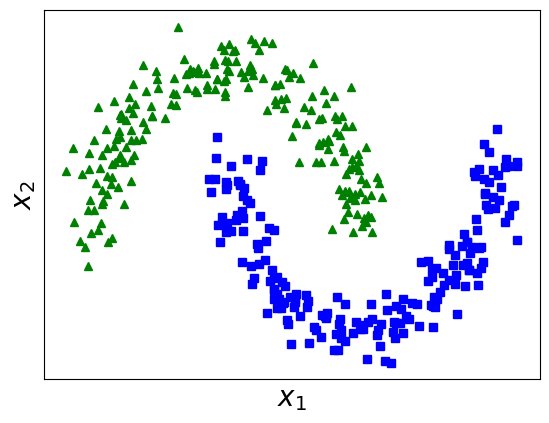

In [215]:
plot_graph(X_train,y_train)

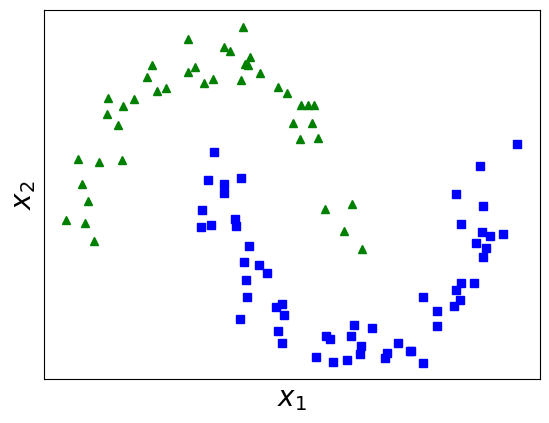

In [216]:
plot_graph(X_test,y_test)

In [217]:
X_train[:10]

array([[-0.53338701,  0.98040744],
       [ 1.94151352,  0.19747214],
       [ 1.57127357, -0.35920336],
       [ 0.86931148,  0.51119558],
       [ 0.98111608,  0.4950539 ],
       [-0.25547966,  0.9773159 ],
       [-0.97003895,  0.05051744],
       [ 0.75214051,  0.57992783],
       [ 0.87001859,  0.11093505],
       [ 2.11332277,  0.1347703 ]])

In [236]:
learning_rate = 0.01
mlp = MLP([2,4,4,1])

In [ ]:
for k in range(200):

    print("*"*40)
    loss = 0.0
    mlp.zero_grad()

    for current_x,current_y in zip(X_train,y_train):
        current_pred = mlp(current_x)
        loss+= (current_pred - current_y)**2
    loss.backward()

    for current_param in mlp.parameters():
        current_param.data -= 0.001 * current_param.grad

    print(k,loss.data)
    
    # break

****************************************
0 152.13293646423418
****************************************
1 94.66742445222779
****************************************
2 83.21415243208884
****************************************
3 76.66129768516566
****************************************
4 72.72015312859703
****************************************
5 69.77422250737452
****************************************
6 67.021501671622
****************************************
7 64.2289256809819
****************************************
8 61.37281246988437
****************************************
9 58.51312114125141
****************************************
10 55.74438376649457
****************************************
11 53.1652642230793
****************************************
12 50.85542346305908
****************************************
13 48.86150875720593
****************************************
14 47.19441336459925
****************************************
15 45.835851880237236
********************